In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import dask.dataframe as dd

## Reading and combining all data in a single dataset 

In [2]:
cat_directory = '../data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


Get filepath of all existing csv files.

In [3]:
mseed_folder_path = r'..\data\lunar\training\data\S12_GradeA'
lunar_data_names = cat['filename'].values

lunar_data_file_path = [os.path.join(mseed_folder_path, f'{file_name}.mseed') for file_name in lunar_data_names]
lunar_data_file_path = [file_path for file_path in lunar_data_file_path if os.path.isfile(file_path)]

# Define reading and preprocessing functions

In [19]:
def read_mseed_darts(file_path):
  """
  Reads an mseed file and returns a Dask DataFrame with data, actual datetime values 
  for time, and sampling rate.

  Args:
      file_path (str): Path to the mseed file.

  Returns:
      dask.dataframe.DataFrame: Dask DataFrame with columns 'data', 'time', and 'sampling_rate'.
  """

  # Read the mseed file
  st = read(file_path)
  tr = st[0]  # Assuming single trace in the mseed file

  # Extract data and sampling rate
  data = tr.data
  sampling_rate = tr.stats.sampling_rate

  # Get actual datetime values for time
  times = []
  for i in range(len(data)):
    time = tr.stats.starttime + i / sampling_rate
    times.append(time.datetime)  # Convert UTCDateTime to datetime object

  # Create a Dask DataFrame
  df = dd.from_pandas(pd.DataFrame({'time': times, 'data': data, 'sampling_rate': sampling_rate}), npartitions=1) 

  return df


def read_mseed_pandas(file_path):
  """
  Reads an mseed file and returns a Pandas DataFrame with data and 
  actual datetime values for time.

  Args:
      file_path (str): Path to the mseed file.

  Returns:
      pandas.DataFrame: DataFrame with columns 'data' and 'time'.
  """

  # Read the mseed file
  st = read(file_path)
  tr = st[0]  # Assuming single trace in the mseed file

  # Extract data
  data = tr.data

  # Get actual datetime values for time
  times = []
  for i in range(len(data)):
    time = tr.stats.starttime + i / tr.stats.sampling_rate
    times.append(time.datetime)  # Convert UTCDateTime to datetime object

  # Create a Pandas DataFrame
  df = pd.DataFrame({'time': times, 'data': data})

  return df


def process_lunar_data_darts(lunar_data_file_path, output_file):
  """
  Lazily reads multiple mseed files, concatenates them into a single Dask DataFrame, 
  removes duplicate entries based on time, and saves the result to a Parquet file.

  Args:
      lunar_data_file_path (list): List of paths to the mseed files.
      output_file (str): Path to the output Parquet file.
  """

  # Create a list to hold the lazy-loaded DataFrames
  lazy_dataframes = []

  for file_path in lunar_data_file_path:
    ddf = read_mseed(file_path)
    lazy_dataframes.append(ddf)

  # Concatenate all Dask DataFrames lazily
  combined_ddf = dd.concat(lazy_dataframes, interleave_partitions=True)

  # Remove duplicates based on the 'time' column
  combined_ddf = combined_ddf.drop_duplicates(subset=['time'])

  # Sort the combined Dask DataFrame by 'time'
  combined_ddf = combined_ddf.sort_values('time')

  # Save the combined Dask DataFrame to a Parquet file
  combined_ddf.to_parquet(output_file, engine='pyarrow', write_index=False)


def process_lunar_data_pandas(lunar_data_file_path, output_file):
  """
  Reads multiple mseed files, concatenates them into a single DataFrame, 
  removes duplicate entries based on time, and saves the result to a CSV file.

  Args:
      lunar_data_file_path (list): List of paths to the mseed files.
      output_file (str): Path to the output CSV file.
  """

  all_data = []
  seen_times = set()

  for file_path in lunar_data_file_path:
    df = read_mseed(file_path)

    # Remove duplicate times
    df_unique = df[~df['time'].isin(seen_times)]
    seen_times.update(df_unique['time'])

    all_data.append(df_unique)

  # Concatenate all DataFrames
  combined_df = pd.concat(all_data, ignore_index=True)

  # Sort the combined DataFrame by 'time'
  combined_df = combined_df.sort_values('time')

  # Save the combined DataFrame to a CSV file
  combined_df.to_csv(output_file, index=False) 

In [5]:
path_to_data_folder = r'..\data\lunar\training\data'
path_to_save_combined_paquet = os.path.join(path_to_data_folder, "combined_data.parquet")
path_to_save_combined_csv = os.path.join(path_to_data_folder, "combined_data.csv")

In [20]:
process_lunar_data_darts(lunar_data_file_path, path_to_save_combined_paquet)

In [ ]:
process_lunar_data_pandas(lunar_data_file_path, path_to_save_combined_csv)
df = pd.read_csv(path_to_save_combined_csv)

In [6]:
ddf = dd.read_parquet(path_to_save_combined_csv, engine='pyarrow')

In [7]:
# Show the first 10 rows
ddf.head(10)

,time,data,sampling_rate
0,1970-01-19 00:00:00.665000,-6.153279e-14,6.625
1,1970-01-19 00:00:00.815943,-7.701288e-14,6.625
2,1970-01-19 00:00:00.966887,-8.396187e-14,6.625
3,1970-01-19 00:00:01.117830,-8.096155e-14,6.625
4,1970-01-19 00:00:01.268774,-7.097599e-14,6.625
5,1970-01-19 00:00:01.419717,-5.882623e-14,6.625
6,1970-01-19 00:00:01.570660,-4.801144e-14,6.625
7,1970-01-19 00:00:01.721604,-3.909115e-14,6.625
8,1970-01-19 00:00:01.872547,-3.042487e-14,6.625
9,1970-01-19 00:00:02.023491,-2.029018e-14,6.625


In [10]:
# Show the first 10 rows
ddf.tail(10)

,time,data,sampling_rate
8381201,1975-06-27 00:00:00.089170,7.402473e-16,6.625
8381202,1975-06-27 00:00:00.240113,7.598239e-16,6.625
8381203,1975-06-27 00:00:00.391057,7.794005e-16,6.625
8381204,1975-06-27 00:00:00.542000,7.989770e-16,6.625
8381205,1975-06-27 00:00:00.692943,3.466912e-17,6.625
8381206,1975-06-27 00:00:00.843887,-3.982647e-16,6.625
8381207,1975-06-27 00:00:00.994830,-5.580877e-16,6.625
8381208,1975-06-27 00:00:01.145774,-6.563002e-16,6.625
8381209,1975-06-27 00:00:01.296717,-3.281501e-16,6.625
8381210,1975-06-27 00:00:01.447660,0.000000e+00,6.625


In [14]:
def reducing_rows_by_mean_average(df, n_parameters, target_column):
    """
    Preprocesses a DART dataset by averaging every n_parameters rows in the 
    target column, while keeping all other columns and reducing them 
    based on the target column's grouping.

    Args:
        df (pandas.DataFrame): The input DART dataset.
        n_parameters (int): The number of rows to average.
        target_column (str): The name of the column to preprocess.

    Returns:
        pandas.DataFrame: The processed dataset with averaged values in the
                         target column and other columns reduced accordingly.
    """

    # Create a new column to group the data for averaging
    df['group'] = df.index // n_parameters

    # Calculate the mean for each group in the target column
    processed_df = df.groupby('group').agg({
        target_column: 'mean',  # Average the target column
        **{col: 'first' for col in df.columns if col != target_column}  # Keep the first value for other columns
    })

    # Reset the index and drop the 'group' column
    processed_df = processed_df.reset_index(drop=True)  # drop=True to avoid the error
    processed_df = processed_df.drop(columns=["group"])

    return processed_df

def preprocess_data_rms(df, window_size=4):
  """
  Preprocesses a dataframe by calculating the absolute root mean square (RMS) 
  over a rolling window.

  Args:
      df (pandas.DataFrame): The input dataframe with a 'data' column.
      window_size (int, optional): The size of the rolling window in samples. 
                                  Defaults to 10.

  Returns:
      pandas.DataFrame: A new dataframe with the 'rms' column containing the 
                       calculated RMS values.
  """

  # Calculate the absolute RMS using a rolling window
  df['data'] = df['data'].abs().rolling(window=window_size, center=True).mean()

  # Drop the initial and final rows with NaN values due to the rolling window
  df = df.dropna()

  return df

In [161]:
def preprocess_df(df):
    df = preprocess_data_rms(df)
    df = reducing_rows_by_mean_average(df, n_parameters=3, target_column="data")

    df = df.drop(columns=["sampling_rate"])

    return df

In [18]:
# Show the first 10 rows
ddf.tail(12)

,time,data,sampling_rate
8381199,1975-06-26 23:59:59.787283,7.010942e-16,6.625
8381200,1975-06-26 23:59:59.938226,7.206707e-16,6.625
8381201,1975-06-27 00:00:00.089170,7.402473e-16,6.625
8381202,1975-06-27 00:00:00.240113,7.598239e-16,6.625
8381203,1975-06-27 00:00:00.391057,7.794005e-16,6.625
8381204,1975-06-27 00:00:00.542000,7.989770e-16,6.625
8381205,1975-06-27 00:00:00.692943,3.466912e-17,6.625
8381206,1975-06-27 00:00:00.843887,-3.982647e-16,6.625
8381207,1975-06-27 00:00:00.994830,-5.580877e-16,6.625
8381208,1975-06-27 00:00:01.145774,-6.563002e-16,6.625


In [13]:
import matplotlib.pyplot as plt

def plot_time_series(df, target_timestamp=None):
  """
  Plots a simple time series wi1th timestamps on the x-axis and data on the y-axis.
  Optionally adds a vertical line at a target timestamp.

  Args:
    df (pandas.DataFrame): DataFrame with 'time' and 'data' columns.
    target_timestamp (str or pd.Timestamp, optional): The timestamp to mark 
                                                      with a vertical line. 
                                                      Defaults to None.
  """

  plt.plot(df['time'], df['data'])
  plt.xlabel('Time')
  plt.ylabel('Data')
  plt.title('Time Series Plot')
  plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

  # Add target timestamp line if provided
  if target_timestamp is not None:
    if isinstance(target_timestamp, str):
      target_timestamp = pd.Timestamp(target_timestamp)  # Convert to Timestamp if needed
    plt.axvline(x=target_timestamp, color='red', linestyle='--', label='Target Time')
    plt.legend()

  plt.show()

In [64]:
reducing_rows_by_mean_average(ddf.tail(100000), 3, "data")

,data,time,sampling_rate
0,-6.146735e-11,1975-06-26 19:48:27.258981,6.625
1,-6.407968e-11,1975-06-26 19:48:27.409925,6.625
2,-2.396186e-11,1975-06-26 19:48:27.862755,6.625
3,1.257381e-11,1975-06-26 19:48:28.315585,6.625
4,2.529633e-11,1975-06-26 19:48:28.768415,6.625
...,...,...,...
33329,6.619410e-16,1975-06-26 23:59:59.334453,6.625
33330,7.206707e-16,1975-06-26 23:59:59.787283,6.625
33331,7.794005e-16,1975-06-27 00:00:00.240113,6.625
33332,-3.072277e-16,1975-06-27 00:00:00.692943,6.625


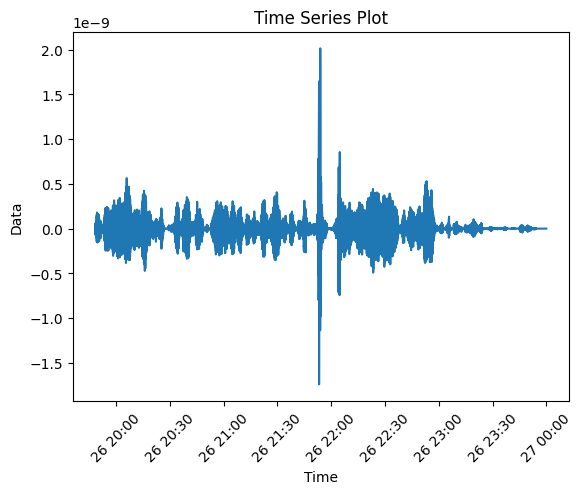

In [37]:
plot_time_series(
    reducing_rows_by_mean_average(ddf.tail(100000), 3, "data")
    )

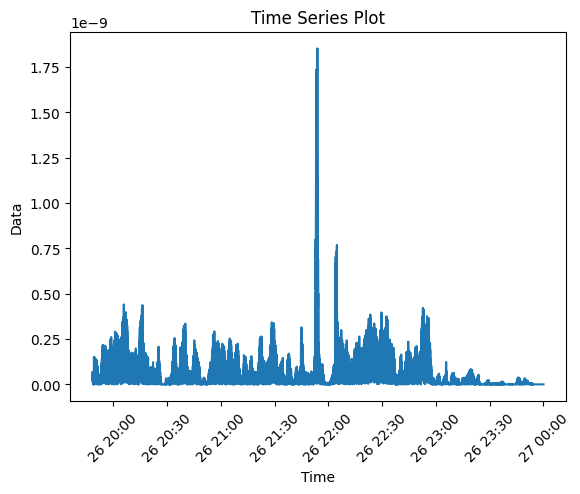

In [53]:
plot_time_series(
    preprocess_df(ddf.tail(100000))
)


In [71]:
preprocess_df(ddf.tail(1000))

,data,time
0,5.343805e-15,1975-06-26 23:57:30.957094
1,4.219826e-15,1975-06-26 23:57:31.258981
2,3.895787e-15,1975-06-26 23:57:31.711811
3,7.118450e-15,1975-06-26 23:57:32.164642
4,3.655607e-15,1975-06-26 23:57:32.617472
...,...,...
328,6.521527e-16,1975-06-26 23:59:59.334453
329,7.108825e-16,1975-06-26 23:59:59.787283
330,7.042885e-16,1975-06-27 00:00:00.240113
331,4.540526e-16,1975-06-27 00:00:00.692943


# Creating DataLoader for training Data

In [113]:
def create_earthquake_dataset(df, earthquake_timestamps, window_size, stride):
    """
    Creates a dataset for earthquake detection from time series data.

    Args:
        df (pandas.DataFrame): DataFrame with 'time' and 'data' columns.
        earthquake_timestamps (list): List of earthquake timestamps.
        window_size (int): The size of the sliding window.
        stride (float): The stride of the sliding window (percentage of window size).

    Yields:
        tuple: A tuple containing the windowed data (X) and the corresponding earthquake labels (y).
    """

    stride_size = int(window_size * stride)
    earthquake_timestamps = set(pd.Timestamp(eq_t) for eq_t in earthquake_timestamps) 
    threshold = pd.Timedelta(seconds=0.12)

    for day, group in df.groupby(df['time'].dt.date):
        for i in range(0, len(group) - window_size + 1, stride_size):
            window = group[i: i + window_size]
            X = window['data'].values

            y = np.zeros(window_size)
            
            # 1. Create a storage for temporary data
            temp_diffs = []

            # 2. Iterate over all X data again
            for timestamp in window['time']:
                # 3. Get difference and select minimum
                diffs = [abs(timestamp - eq_t) for eq_t in earthquake_timestamps]
                min_diff = min(diffs)
                # 4. Store the minimum difference
                temp_diffs.append(min_diff)

            # Find the index with the minimum difference
            min_diff_index = np.argmin(temp_diffs)
            
            # Check if the minimum difference is within the threshold
            if temp_diffs[min_diff_index] <= threshold:
                y[min_diff_index] = 1

            return X, y
        


class EarthquakeDataLoader:
    def __init__(self, data, earthquake_timestamps, window_size, stride):
        """
        Initializes the EarthquakeDataLoader and generates all windows.

        Args:
            data (pd.DataFrame): DataFrame with 'time' and 'data' columns.
            earthquake_timestamps (list): List of timestamps for earthquakes.
            window_size (int): Size of the sliding window.
            stride (float): Percentage of the window size for the stride (0 < stride < 1).
        """
        self.data = data.copy()
        self.data['time'] = self.data['time'].astype(np.int64)
        self.earthquake_timestamps = earthquake_timestamps
        self.window_size = window_size
        self.stride = stride
        self.all_windows = self.generate_windows()  # Generate windows immediately

    def generate_windows(self):
        """
        Generates all windows and targets.
        """
        self.data['day'] = self.data['time'].dt.date  # Add a 'day' column for grouping
        all_windows = []
        for day, group in self.data.groupby('day'):
            group_data = group['data'].values  # Get data values for the current day

            stride = int(self.window_size * self.stride)  # Calculate stride as a percentage of window_size
            num_windows = int((len(group_data) - self.window_size) // stride + 1)  # Use calculated stride

            for i in range(num_windows):
                start_idx = int(i * stride)  # Use calculated stride
                end_idx = start_idx + self.window_size
                window_data = group_data[start_idx:end_idx]
                window_time = group['time'].iloc[start_idx:end_idx]

                # Find target index in the window
                target_index = self.find_target_index(window_time)

                # Create target sequence
                target_seq = np.zeros(self.window_size)
                if target_index is not None:
                    target_seq[target_index] = 1

                all_windows.append((window_data.reshape(-1, 1), target_seq.reshape(-1, 1)))

        return all_windows

    def find_target_index(self, window_time):
        """
        Finds the index of the closest timestamp to an earthquake in the window.

        Args:
            window_time (pd.Series): Series of timestamps in the current window.

        Returns:
            int or None: Index of the closest timestamp, or None if no earthquake is found.
        """
        for eq_time in self.earthquake_timestamps:
            closest_time = window_time[window_time.apply(lambda t: abs(t - eq_time).total_seconds() <= 1)]
            if not closest_time.empty:
                return closest_time.index[0] - window_time.index[0]
        return None

    def __getitem__(self, index):
        """
        Allows accessing windows using indexing.
        """
        return self.all_windows[index]

    def __len__(self):
        """
        Returns the total number of windows.
        """
        return len(self.all_windows)


Now, we need to understand what shold be the aproximative windows size of keeping the data

In [154]:
def get_data_between_timestamps(df, start_time, end_time):
  """
  Returns data from a DataFrame between two given timestamps.

  Args:
    df (pandas.DataFrame): The input DataFrame with a 'time' column.
    start_time (pd.Timestamp): The starting timestamp.
    end_time (pd.Timestamp): The ending timestamp.

  Returns:
    pandas.DataFrame: A new DataFrame containing only the data within the 
                     specified time range.
  """

  # Filter the DataFrame based on the time range
  filtered_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)].repartition(npartitions=1) 
  return filtered_df

In [164]:
start_time = pd.Timestamp("1970-01-19T20:00:00.000000")
end_time = pd.Timestamp("1970-01-19T21:00:00.000000")
first_quaqe = pd.Timestamp("1970-01-19T20:25:00.000000") # Defining a timestamp from the category file

filtered_data = get_data_between_timestamps(ddf, start_time, end_time)
filtered_data = filtered_data.compute()  

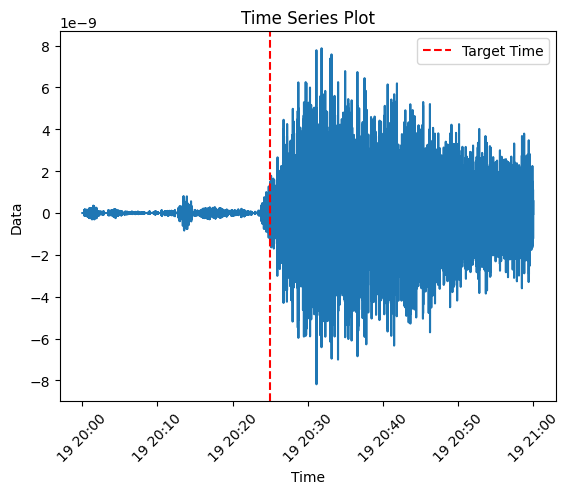

In [168]:
plot_time_series(filtered_data, target_timestamp=first_quaqe)

Getting the size of the window

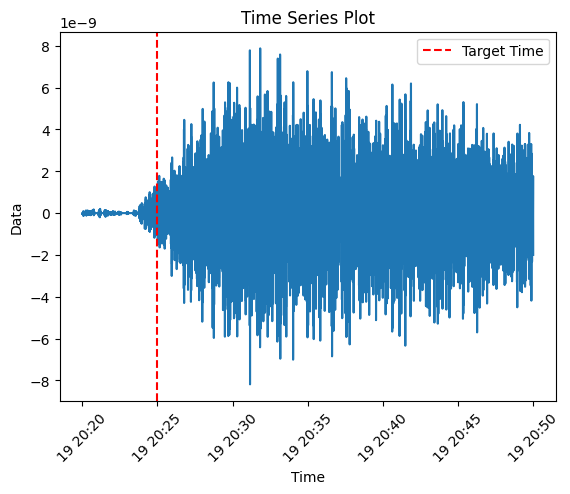

In [169]:
start_time = pd.Timestamp("1970-01-19T20:20:00.000000")
end_time = pd.Timestamp("1970-01-19T20:50:00.000000")
first_quaqe = pd.Timestamp("1970-01-19T20:25:00.000000") # Defining a timestamp from the category file

filtered_data_windows = get_data_between_timestamps(ddf, start_time, end_time)
filtered_data_windows = filtered_data_windows.compute() 

plot_time_series(filtered_data_windows, target_timestamp=first_quaqe)

In [170]:
filtered_data_windows

,time,data,sampling_rate
484946,1970-01-19 20:20:00.061226,-3.500079e-11,6.625
484947,1970-01-19 20:20:00.212170,-1.444117e-11,6.625
484948,1970-01-19 20:20:00.363113,9.176098e-14,6.625
484949,1970-01-19 20:20:00.514057,-5.968071e-12,6.625
484950,1970-01-19 20:20:00.665000,-2.475654e-11,6.625
...,...,...,...
496866,1970-01-19 20:49:59.306509,1.755984e-09,6.625
496867,1970-01-19 20:49:59.457453,1.769691e-09,6.625
496868,1970-01-19 20:49:59.608396,9.716733e-10,6.625
496869,1970-01-19 20:49:59.759340,-4.669657e-10,6.625


We identified here, that to catch a moment with Lunar quaqe we should have a window with size of 12000 elements

Get list of quake_timestamps, in order to create dataloader

In [63]:
category_df = pd.read_csv(r"..\data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv")

quake_timestamps = category_df["time_abs(%Y-%m-%dT%H:%M:%S.%f)"].values
quake_timestamps_pandas = [pd.to_datetime(ts) for ts in quake_timestamps] 

In [20]:
ty = lunar_data_file_path[0]
ty = read_mseed_pandas(ty)
ty

,time,data
0,1970-01-19 00:00:00.665000,-6.153279e-14
1,1970-01-19 00:00:00.815943,-7.701288e-14
2,1970-01-19 00:00:00.966887,-8.396187e-14
3,1970-01-19 00:00:01.117830,-8.096155e-14
4,1970-01-19 00:00:01.268774,-7.097599e-14
...,...,...
572410,1970-01-20 00:00:02.174434,-1.472713e-14
572411,1970-01-20 00:00:02.325377,-1.956104e-14
572412,1970-01-20 00:00:02.476321,-2.240307e-14
572413,1970-01-20 00:00:02.627264,-2.998405e-14


In [40]:
window_size = 12000
stride = 0.25
DATASET = create_earthquake_dataset(ty.head(100), quake_timestamps, 10, stride)

In [108]:
dataloader = EarthquakeDataLoader(ty.head(100), quake_timestamps_pandas, 10, stride)

# Access the first window
X, y = dataloader[0] 

C:\Users\crist\AppData\Local\Temp\ipykernel_14952\3585340221.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['day'] = self.data['time'].dt.date  # Add a 'day' column for grouping


In [112]:
dataloader[2]

(array([[-7.09759916e-14],
        [-5.88262252e-14],
        [-4.80114401e-14],
        [-3.90911533e-14],
        [-3.04248713e-14],
        [-2.02901838e-14],
        [-8.58738755e-15],
        [ 3.05476291e-15],
        [ 1.25768415e-14],
        [ 1.89732488e-14]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [95]:
data_list[0]

(array([[-6.15327896e-14],
        [-7.70128843e-14],
        [-8.39618673e-14],
        [-8.09615455e-14],
        [-7.09759916e-14],
        [-5.88262252e-14],
        [-4.80114401e-14],
        [-3.90911533e-14],
        [-3.04248713e-14],
        [-2.02901838e-14]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [114]:
import pandas as pd

In [115]:
df = pd.read_csv(r"..\data\lunar\test\data\S12_GradeB\xa.s12.00.mhz.1969-12-16HR00_evid00006.csv")

In [117]:
df["time_rel(sec)"] = df["time_rel(sec)"].apply(lambda x: int(x * 100))

df[""]

In [121]:
df.to_csv("1969_12_17.csv")

In [120]:
df

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1969-12-16T00:00:00.178000,0.000000e+00,0.000000e+00
1,1969-12-16T00:00:00.328943,1.509434e+01,-5.576940e-15
2,1969-12-16T00:00:00.479887,3.018868e+01,-1.115388e-14
3,1969-12-16T00:00:00.630830,4.528302e+01,-1.673082e-14
4,1969-12-16T00:00:00.781774,6.037736e+01,-2.230776e-14
...,...,...,...
572418,1969-12-17T00:00:02.894981,8.640272e+06,-1.767212e-14
572419,1969-12-17T00:00:03.045925,8.640287e+06,-2.535490e-14
572420,1969-12-17T00:00:03.196868,8.640302e+06,-3.008261e-14
572421,1969-12-17T00:00:03.347811,8.640317e+06,-4.156843e-14


In [124]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt  # Import matplotlib for plotting

class EarthquakeDataLoader:
    def __init__(self, data, earthquake_timestamps, window_size, stride):
        """
        Initializes the EarthquakeDataLoader and generates all windows.

        Args:
            data (pd.DataFrame): DataFrame with 'AbsTime', 'RelTime', and 'Value' columns.
            earthquake_timestamps (list): List of timestamps for earthquakes.
            window_size (int): Size of the sliding window.
            stride (float): Percentage of the window size for the stride (0 < stride < 1).
        """
        self.data = data.copy()  # Create a copy of the DataFrame
        
        # Convert 'AbsTime' to datetime64[ns] if it's not already
        self.data['AbsTime'] = pd.to_datetime(self.data['AbsTime'])  
        
        self.data['AbsTime'] = self.data['AbsTime'].astype(np.int64)  # Convert 'AbsTime' to int64
        self.earthquake_timestamps = earthquake_timestamps
        self.window_size = window_size
        self.stride = stride
        self.all_windows = self.generate_windows()  # Generate windows immediately

    def generate_windows(self):
        """
        Generates all windows and targets.
        """
        # Ensure 'AbsTime' is in datetime format before using .dt accessor
        self.data['AbsTime'] = pd.to_datetime(self.data['AbsTime'])  
        
        self.data['day'] = self.data['AbsTime'].dt.date  # Add a 'day' column for grouping based on 'AbsTime'
        all_windows = []
        for day, group in self.data.groupby('day'):
            group_data = group['Value'].values  # Get 'Value' values for the current day

            stride = int(self.window_size * self.stride)  # Calculate stride as a percentage of window_size
            num_windows = int((len(group_data) - self.window_size) // stride + 1)  # Use calculated stride

            for i in range(num_windows):
                start_idx = int(i * stride)  # Use calculated stride
                end_idx = start_idx + self.window_size
                window_data = group_data[start_idx:end_idx]
                window_time = group['AbsTime'].iloc[start_idx:end_idx]  # Use 'AbsTime' for time reference

                # Find target index in the window
                target_index = self.find_target_index(window_time)

                # Create target sequence
                target_seq = np.zeros(self.window_size)
                if target_index is not None:
                    target_seq[target_index] = 1

                all_windows.append((window_data.reshape(-1, 1), target_seq.reshape(-1, 1)))

        return all_windows

    def find_target_index(self, window_time):
        """
        Finds the index of the closest timestamp to an earthquake in the window.

        Args:
            window_time (pd.Series): Series of 'AbsTime' timestamps in the current window.

        Returns:
            int or None: Index of the closest timestamp, or None if no earthquake is found.
        """
        for eq_time in self.earthquake_timestamps:
            closest_time = window_time[window_time.apply(lambda t: abs(t - eq_time).total_seconds() <= 1)]
            if not closest_time.empty:
                return closest_time.index[0] - window_time.index[0]
        return None

    def __getitem__(self, index):
        """
        Allows accessing windows using indexing.
        """
        return self.all_windows[index]

    def __len__(self):
        """
        Returns the total number of windows.
        """
        return len(self.all_windows)

    def save(self, filename):
        """
        Saves the dataloader to a pickle file.

        Args:
            filename (str): Name of the pickle file.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        """
        Loads the dataloader from a pickle file.

        Args:
            filename (str): Name of the pickle file.

        Returns:
            EarthquakeDataLoader: Loaded dataloader instance.
        """
        with open(filename, 'rb') as f:
            dataloader = pickle.load(f)
            dataloader.data['AbsTime'] = pd.to_datetime(dataloader.data['AbsTime'])  # Convert 'AbsTime' back to datetime
            return dataloader

    def __add__(self, other):
        """
        Combines two EarthquakeDataLoader instances.
        """
        if not isinstance(other, EarthquakeDataLoader):
            raise TypeError("Unsupported operand type for +: 'EarthquakeDataLoader' and '{}'".format(type(other)))

        combined_data = pd.concat([self.data, other.data])
        combined_earthquake_timestamps = self.earthquake_timestamps + other.earthquake_timestamps
        combined_dataloader = EarthquakeDataLoader(
            combined_data, 
            combined_earthquake_timestamps, 
            self.window_size, 
            self.stride
        )
        return combined_dataloader

In [122]:
path_to_data = r'..\data\lunar\training\pkl'

In [ ]:
for idx, file_pkl in enumerate(os.listdir(path_to_data)):
    path_pkl = os.path.join(path_to_data, file_pkl)
    current_QuakeDataLoader = EarthquakeDataLoader.load(path_pkl)
    
    if idx != 0:
        data = data + current_QuakeDataLoader
    else:
        data = EarthquakeDataLoader.load(path_pkl)

In [ ]:
class EarthquakeDataLoader:
    def __init__(self, data, earthquake_timestamps, window_size, stride):
        """
        Initializes the EarthquakeDataLoader and generates all windows.

        Args:
            data (pd.DataFrame): DataFrame with 'AbsTime', 'RelTime', and 'Value' columns.
            earthquake_timestamps (list): List of timestamps for earthquakes.
            window_size (int): Size of the sliding window.
            stride (float): Percentage of the window size for the stride (0 < stride < 1).
        """
        self.data = data.copy()  # Create a copy of the DataFrame
        
        # Convert 'AbsTime' to datetime64[ns] if it's not already
        self.data['AbsTime'] = pd.to_datetime(self.data['AbsTime'])  
        
        self.data['AbsTime'] = self.data['AbsTime'].astype(np.int64)  # Convert 'AbsTime' to int64
        self.earthquake_timestamps = earthquake_timestamps
        self.window_size = window_size
        self.stride = stride
        self.all_windows = self.generate_windows()  # Generate windows immediately

    def generate_windows(self):
        """
        Generates all windows and targets.
        """
        # Ensure 'AbsTime' is in datetime format before using .dt accessor
        self.data['AbsTime'] = pd.to_datetime(self.data['AbsTime'])  
        
        self.data['day'] = self.data['AbsTime'].dt.date  # Add a 'day' column for grouping based on 'AbsTime'
        all_windows = []
        for day, group in self.data.groupby('day'):
            group_data = group['Value'].values  # Get 'Value' values for the current day

            stride = int(self.window_size * self.stride)  # Calculate stride as a percentage of window_size
            num_windows = int((len(group_data) - self.window_size) // stride + 1)  # Use calculated stride

            for i in range(num_windows):
                start_idx = int(i * stride)  # Use calculated stride
                end_idx = start_idx + self.window_size
                window_data = group_data[start_idx:end_idx]
                window_time = group['AbsTime'].iloc[start_idx:end_idx]  # Use 'AbsTime' for time reference

                # Find target index in the window
                target_index = self.find_target_index(window_time)

                # Create target sequence
                target_seq = np.zeros(self.window_size)
                if target_index is not None:
                    target_seq[target_index] = 1

                all_windows.append((window_data.reshape(-1, 1), target_seq.reshape(-1, 1)))

        return all_windows

    def find_target_index(self, window_time):
        """
        Finds the index of the closest timestamp to an earthquake in the window.

        Args:
            window_time (pd.Series): Series of 'AbsTime' timestamps in the current window.

        Returns:
            int or None: Index of the closest timestamp, or None if no earthquake is found.
        """
        for eq_time in self.earthquake_timestamps:
            closest_time = window_time[window_time.apply(lambda t: abs(t - eq_time).total_seconds() <= 1)]
            if not closest_time.empty:
                return closest_time.index[0] - window_time.index[0]
        return None

    def __getitem__(self, index):
        """
        Allows accessing windows using indexing.
        """
        return self.all_windows[index]

    def __len__(self):
        """
        Returns the total number of windows.
        """
        return len(self.all_windows)

    def save(self, filename):
        """
        Saves the dataloader to a pickle file.

        Args:
            filename (str): Name of the pickle file.
        """
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def load(filename):
        """
        Loads the dataloader from a pickle file.

        Args:
            filename (str): Name of the pickle file.

        Returns:
            EarthquakeDataLoader: Loaded dataloader instance.
        """
        with open(filename, 'rb') as f:
            dataloader = pickle.load(f)
            dataloader.data['AbsTime'] = pd.to_datetime(dataloader.data['AbsTime'])  # Convert 'AbsTime' back to datetime
            return dataloader

    def __add__(self, other):
        """
        Combines two EarthquakeDataLoader instances.
        """
        if not isinstance(other, EarthquakeDataLoader):
            raise TypeError("Unsupported operand type for +: 'EarthquakeDataLoader' and '{}'".format(type(other)))

        combined_data = pd.concat([self.data, other.data])
        combined_earthquake_timestamps = self.earthquake_timestamps + other.earthquake_timestamps
        combined_dataloader = EarthquakeDataLoader(
            combined_data, 
            combined_earthquake_timestamps, 
            self.window_size, 
            self.stride
        )
        return combined_dataloader